In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder


In [2]:
parking_data=pd.read_csv("merged_parking.csv")

In [3]:
parking_data.head()

,Unnamed: 0,Block,Street,EntryDate,Bylaw,Section,Status,InfractionText,Year,HBLOCK,STREETUSE,coord_1,coord_2
0,0,1400,Kingsway,2017-08-23,2849,17.1,IS,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2017.0,1400 KINGSWAY,Arterial,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]"
1,1,1400,KINGSWAY,2018-07-25,2849,17.1,IS,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2018.0,1400 KINGSWAY,Arterial,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]"
2,2,1400,KINGSWAY,2019-07-03,2849,19.1(G),VA,STOP ON A LANE WITHIN AN AREA 1.5M FROM EITHER...,2019.0,1400 KINGSWAY,Arterial,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]"
3,3,1400,KINGSWAY,2018-01-08,2849,17.1,IS,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2018.0,1400 KINGSWAY,Arterial,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]"
4,4,1400,KINGSWAY,2018-01-04,2849,17.1,IS,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2018.0,1400 KINGSWAY,Arterial,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]"


In [4]:
data = ['InfractionText','Street','Status','HBLOCK','STREETUSE']

In [5]:
for column in data:
    ord_enc = OrdinalEncoder()
    parking_data[column] = ord_enc.fit_transform(parking_data[[column]])

In [6]:
parking_data['co-ordinates'] = parking_data[parking_data.columns[11:]].apply(lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

In [7]:
X = parking_data['EntryDate']
Y = parking_data['InfractionText']
Y1 = parking_data['co-ordinates']

In [8]:
new_data = [X,Y,Y1]

In [9]:
prediction_df = pd.DataFrame(new_data).T


In [10]:
from datetime import datetime

In [11]:
prediction_df["EntryDate"]=prediction_df["EntryDate"].apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))

In [12]:
series_value = prediction_df.values

In [13]:
total_tickets = prediction_df.groupby(prediction_df["EntryDate"])['InfractionText'].count()
total_tickets.describe()

count    578.000000
mean      61.378893
std       77.623475
min        1.000000
25%       10.000000
50%       32.000000
75%       87.000000
max      491.000000
Name: InfractionText, dtype: float64

In [14]:
total_tickets= total_tickets[0:365]
total_tickets.describe()

count    365.000000
mean      56.430137
std       65.658488
min        1.000000
25%       10.000000
50%       30.000000
75%       85.000000
max      353.000000
Name: InfractionText, dtype: float64

<AxesSubplot:xlabel='EntryDate'>

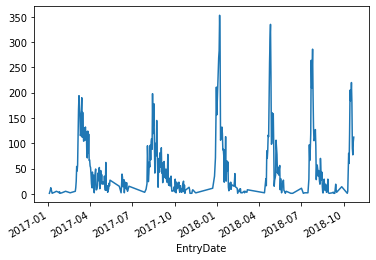

In [15]:
total_tickets.plot()

In [16]:
total_tickets_mean = total_tickets.rolling(window=12).mean()

In [17]:
total_tickets_mean=total_tickets_mean.dropna()

<AxesSubplot:xlabel='EntryDate'>

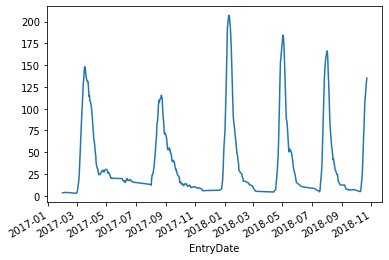

In [18]:
total_tickets_mean.plot()
# total_tickets_mean

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [20]:
decomposition = seasonal_decompose(x=total_tickets_mean, extrapolate_trend='freq', period=int(len(total_tickets_mean)/2))


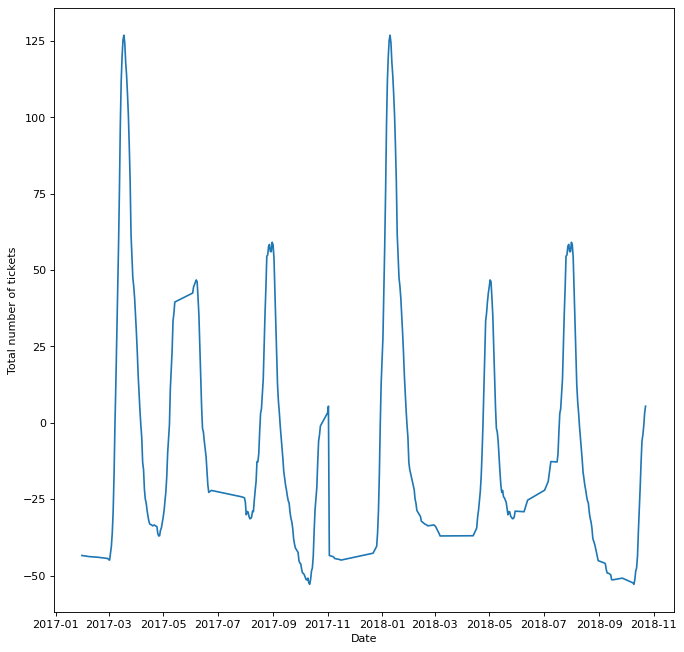

In [21]:
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(decomposition.seasonal)
plt.xlabel('Date')
plt.ylabel('Total number of tickets')
plt.show()


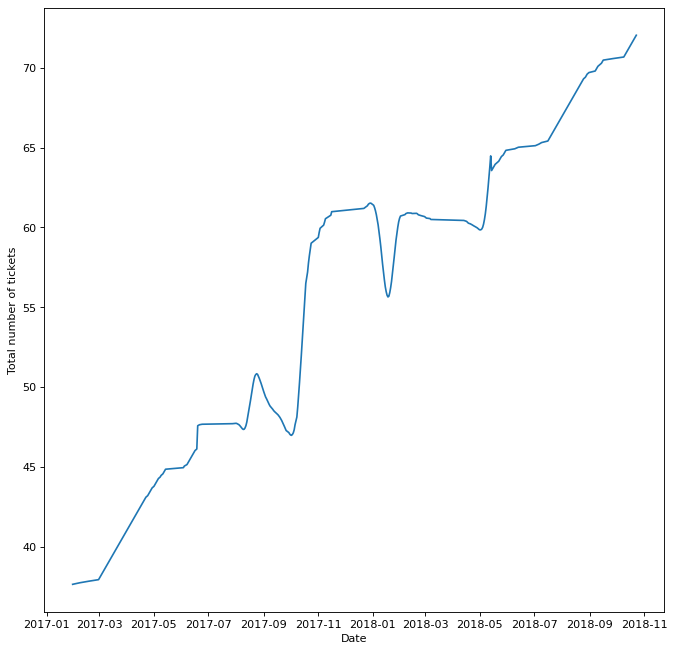

In [22]:
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(decomposition.trend)
plt.xlabel('Date')
plt.ylabel('Total number of tickets')
plt.show()



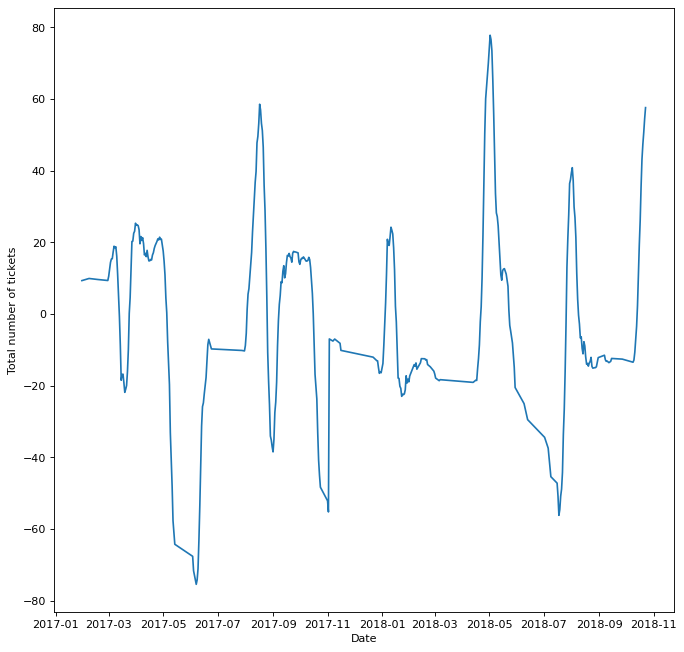

In [23]:
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(decomposition.resid)
plt.xlabel('Date')
plt.ylabel('Total number of tickets')
plt.show()


<h2>BASE LINE MODEL</h2>



The previous value is the best reflection of the future value series(t+1)

In [24]:
total_coordinates=prediction_df.groupby(['EntryDate','co-ordinates','InfractionText'])['InfractionText'].count()


In [35]:
baseline_df = pd.concat([total_coordinates,total_coordinates.shift(1)],axis=1)

In [27]:
baseline_df.columns =['Actual_ticket_count','Forecast_ticket_count']

In [227]:
baseline_df.head()

Actual_ticket_count  \
EntryDate  co-ordinates                                       InfractionText                        
2017-01-03 [-123.05969934101618, 49.28480845599848],[-123.... 24.0                              1   
2017-01-05 [-123.11786601656868, 49.28009446774853],[-123.... 14.0                              1   
           [-123.11848760269254, 49.278412209736196],[-123... 14.0                              1   
           [-123.11897220754433, 49.27664157636647],[-123.... 14.0                              2   
           [-123.11952591787794, 49.27699993083262],[-123.... 14.0                              1   

                                                                              Forecast_ticket_count  
EntryDate  co-ordinates                                       InfractionText                         
2017-01-03 [-123.05969934101618, 49.28480845599848],[-123.... 24.0                              NaN  
2017-01-05 [-123.11786601656868, 49.28009446774853],[-123.... 14.0                              1.0  
           [-123.11848760269254, 49.278412209736196],[-123... 14.0                              1.0  
           [-123.11897220754433, 49.27664157636647],[-123.... 14.0                              1.0  
           [-123.11952591787794, 49.27699993083262],[-123.... 14.0                              2.0

In [28]:
from sklearn.metrics import mean_squared_error
import numpy as np



remove the first nan value

In [29]:
baseline_df = baseline_df[1:] 
# baseline_df.tail()

In [30]:
baseline_mse = mean_squared_error(baseline_df.Actual_ticket_count,baseline_df.Forecast_ticket_count)

In [31]:
baseline_mse

0.6131076751636718

In [32]:
np.sqrt(baseline_mse)

0.7830119253010593

<h2>ARIMA MODEL</h2>

Autoregressive(p)- The current value is correlated with the previous value and the previous value is the best reflection of the current value.

integrated(d)

moving average (q)- smoothing moving the error and noise from the data

In [36]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

Plot_acf is to indentify parameter Q
Arima(p,d,q)

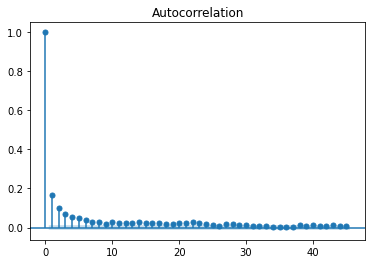

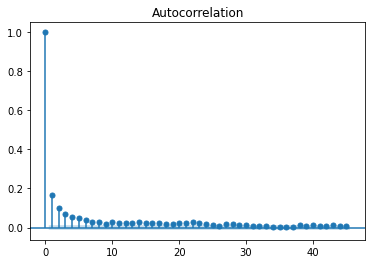

In [38]:
plot_acf(total_coordinates)

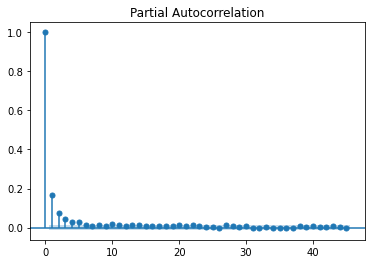

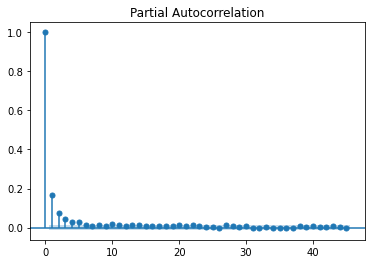

In [39]:
plot_pacf(total_coordinates)

p = 2,3 d =0,q = 3,4

In [43]:
total_coordinates.size

28717

In [44]:
from sklearn.model_selection import train_test_split


In [47]:
train = total_coordinates[0:28000]
test = total_coordinates[28000:28717]

In [60]:
test.size

717

In [48]:
from statsmodels.tsa.arima_model import ARIMA

In [55]:
model = ARIMA(train,order = (5,0,4)).fit()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [57]:
model.aic

50115.56657494317

In [61]:
forecast = model.forecast(steps =717)[0]

In [62]:
forecast

array([1.64027137, 1.50133677, 1.44456592, 1.4037148 , 1.37162103,
       1.35949971, 1.35377793, 1.33953762, 1.33055615, 1.33292563,
       1.32876018, 1.31789839, 1.3173523 , 1.32022262, 1.31218736,
       1.3054955 , 1.30938708, 1.30811717, 1.29869228, 1.2977794 ,
       1.30179817, 1.29570323, 1.28889373, 1.29252013, 1.29295072,
       1.28451327, 1.28285711, 1.28745223, 1.28307203, 1.27618436,
       1.27926755, 1.28106347, 1.27366526, 1.27125733, 1.27608675,
       1.27328716, 1.26644912, 1.26882148, 1.27168272, 1.26537609,
       1.26227017, 1.26704784, 1.2656819 , 1.2590345 , 1.26059439,
       1.26423698, 1.25905492, 1.25534615, 1.25983646, 1.25974235,
       1.25342662, 1.25412938, 1.25828789, 1.25423935, 1.25005194,
       1.25406824, 1.25507171, 1.24921937, 1.24906913, 1.25349997,
       1.25056789, 1.24604425, 1.24944698, 1.25136495, 1.24609133,
       1.24513298, 1.24961755, 1.24775881, 1.24304996, 1.24574408,
       1.24838907, 1.24378801, 1.24209917, 1.24644654, 1.24559

In [63]:
np.sqrt(mean_squared_error(test,forecast))

0.676437229383252